[View in Colaboratory](https://colab.research.google.com/github/ajoshiusc/brainsync/blob/master/deep_rigid.ipynb)

------------------------------
Loading and preprocessing train data...
------------------------------
Creating and compiling model...
Fitting Model
Train on 204 samples, validate on 52 samples
Epoch 1/50
204/204 [==============================] - 2s 11ms/step - loss: 508.1583 - mean_squared_error: 508.1583 - val_loss: 450.4707 - val_mean_squared_error: 450.4707
Epoch 2/50
204/204 [==============================] - 1s 5ms/step - loss: 377.9397 - mean_squared_error: 377.9397 - val_loss: 449.1653 - val_mean_squared_error: 449.1653
Epoch 3/50
204/204 [==============================] - 1s 5ms/step - loss: 377.5588 - mean_squared_error: 377.5588 - val_loss: 445.3497 - val_mean_squared_error: 445.3497
Epoch 4/50
204/204 [==============================] - 1s 5ms/step - loss: 377.3866 - mean_squared_error: 377.3866 - val_loss: 449.8622 - val_mean_squared_error: 449.8622
Epoch 5/50
204/204 [==============================] - 1s 5ms/step - loss: 377.7384 - mean_squared_error: 377.7384 - val_loss: 

Epoch 12/50
204/204 [==============================] - 1s 5ms/step - loss: 379.3862 - mean_squared_error: 379.3862 - val_loss: 449.7745 - val_mean_squared_error: 449.7745
Epoch 13/50
204/204 [==============================] - 1s 5ms/step - loss: 377.8173 - mean_squared_error: 377.8173 - val_loss: 449.9010 - val_mean_squared_error: 449.9010
Epoch 14/50
204/204 [==============================] - 1s 5ms/step - loss: 377.7513 - mean_squared_error: 377.7513 - val_loss: 449.7985 - val_mean_squared_error: 449.7985
Epoch 15/50
204/204 [==============================] - 1s 5ms/step - loss: 377.5177 - mean_squared_error: 377.5177 - val_loss: 448.9451 - val_mean_squared_error: 448.9451
Epoch 16/50
204/204 [==============================] - 1s 5ms/step - loss: 376.7106 - mean_squared_error: 376.7106 - val_loss: 442.5843 - val_mean_squared_error: 442.5843
Epoch 17/50
204/204 [==============================] - 1s 5ms/step - loss: 377.7985 - mean_squared_error: 377.7985 - val_loss: 446.5954 - val_mea

204/204 [==============================] - 1s 5ms/step - loss: 82.5677 - mean_squared_error: 82.5677 - val_loss: 70.9038 - val_mean_squared_error: 70.9038
Epoch 25/50
204/204 [==============================] - 1s 5ms/step - loss: 79.7714 - mean_squared_error: 79.7714 - val_loss: 124.7839 - val_mean_squared_error: 124.7839
Epoch 26/50
204/204 [==============================] - 1s 5ms/step - loss: 67.0161 - mean_squared_error: 67.0161 - val_loss: 71.4189 - val_mean_squared_error: 71.4189
Epoch 27/50
204/204 [==============================] - 1s 5ms/step - loss: 42.0281 - mean_squared_error: 42.0281 - val_loss: 48.1301 - val_mean_squared_error: 48.1301
Epoch 28/50
204/204 [==============================] - 1s 5ms/step - loss: 30.0867 - mean_squared_error: 30.0867 - val_loss: 43.8250 - val_mean_squared_error: 43.8250
Epoch 29/50
204/204 [==============================] - 1s 5ms/step - loss: 31.4420 - mean_squared_error: 31.4420 - val_loss: 40.4341 - val_mean_squared_error: 40.4341
Epoch 30

204/204 [==============================] - 1s 5ms/step - loss: 12.4096 - mean_squared_error: 12.4096 - val_loss: 25.7913 - val_mean_squared_error: 25.7913
Epoch 37/50
204/204 [==============================] - 1s 5ms/step - loss: 9.6820 - mean_squared_error: 9.6820 - val_loss: 28.3509 - val_mean_squared_error: 28.3509
Epoch 38/50
204/204 [==============================] - 1s 5ms/step - loss: 10.5510 - mean_squared_error: 10.5510 - val_loss: 27.1880 - val_mean_squared_error: 27.1880
Epoch 39/50
204/204 [==============================] - 1s 5ms/step - loss: 9.1223 - mean_squared_error: 9.1223 - val_loss: 24.3717 - val_mean_squared_error: 24.3717
Epoch 40/50
204/204 [==============================] - 1s 5ms/step - loss: 8.6609 - mean_squared_error: 8.6609 - val_loss: 28.0091 - val_mean_squared_error: 28.0091
Epoch 41/50
204/204 [==============================] - 1s 5ms/step - loss: 7.9387 - mean_squared_error: 7.9387 - val_loss: 30.5067 - val_mean_squared_error: 30.5067
Epoch 42/50
204/20

204/204 [==============================] - 1s 5ms/step - loss: 5.2877 - mean_squared_error: 5.2877 - val_loss: 27.4756 - val_mean_squared_error: 27.4756
Epoch 49/50
204/204 [==============================] - 1s 5ms/step - loss: 5.2425 - mean_squared_error: 5.2425 - val_loss: 33.6859 - val_mean_squared_error: 33.6859
Epoch 50/50
204/204 [==============================] - 1s 5ms/step - loss: 5.6378 - mean_squared_error: 5.6378 - val_loss: 27.6266 - val_mean_squared_error: 27.6266
dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


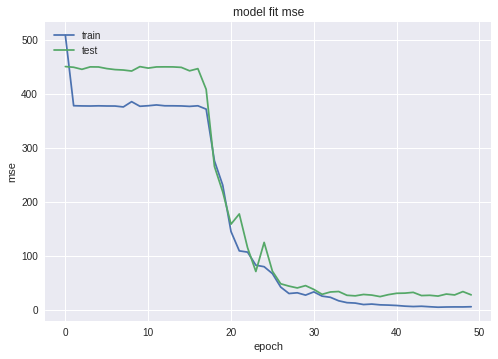

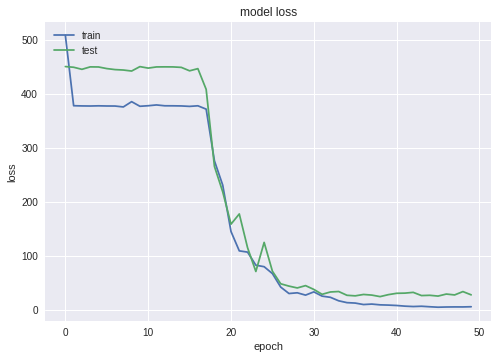

Test data...


In [9]:
#AUM
#Shree Ganeshaya Namaha
from skimage import transform as tf
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage.io import imread
from keras.layers import Input,Conv2D,concatenate,MaxPooling2D,Flatten,Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import numpy as np
from numpy.random import uniform
import matplotlib.pyplot as plt
from skimage.viewer import ImageViewer
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter


from google.colab import files
uploaded = files.upload()


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

from keras import losses
img_rows = 128
img_cols = 128


#taken from: https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)



def get_rr_net():
    inputs = Input((img_rows, img_cols, 2))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    flat1 = Flatten()(conv5)
    d1= Dense(64,activation='relu')(flat1)
    out_theta = Dense(3)(d1)
#    conv_tx = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_ty = Conv2D(1, (1, 1), activation=final_activation)(conv5)
#    conv_theta = Conv2D(1, (1, 1), activation='tanh')(conv5)

#    out_img = rotate(inputs,conv_theta)

    model = Model(inputs=[inputs], outputs=out_theta)

    model.compile(optimizer='adam', loss=losses.mean_squared_error, metrics=['mse'])

    return model


def gen_train_data(img, N=1024):
    imgs_train = np.zeros((N, img.shape[0], img.shape[1], 2))
    noise = uniform(low=-1,high=1,size=imgs_train.shape)
    out_train = np.zeros((N, 3))
    rot = uniform(low=-60, high=60, size=(N,1))
    tx = uniform(low=-2, high=2, size=(N,1))
    ty = uniform(low=-2, high=2, size=(N,1))
    out_train[:,0]=rot.squeeze()
    out_train[:,1]=tx.squeeze()
    out_train[:,2]=ty.squeeze()

    in_rot = uniform(low=-60, high=60, size=(N,1))
 
    for j in range(N):
      
#        img2 = tf.warp(img,aff)
        img2 = rotate(img, in_rot[j],mode='edge')
        img2 -= np.mean(img2)
        img2 /= np.std(img2)
        img2 = elastic_transform(img2, img2.shape[1] * 2, img2.shape[1] * 0.08,img2.shape[1] * 0.08)
        imgs_train[j, :, :, 0] = img2 + noise[j,:,:,0]
        aff = tf.AffineTransform(rotation = (np.pi/180.0)*rot[j], translation=(tx[j],ty[j]))

        #img3 = 10-1*np.tanh(img2) + 0*  noise[j,:,:,1]#
        img3 = 10-1*np.tanh(tf.warp(img2, aff, mode='edge')) +  noise[j,:,:,1]#
        img3 = elastic_transform(img3, img3.shape[1] * 2, img3.shape[1] * 0.08,img3.shape[1] * 0.08)

        img3 -= np.mean(img3)
        img3 /= np.std(img3)
        imgs_train[j, :, :, 1] = img3
        
        if 0:
            viewer = ImageViewer(img3)
            viewer.show()

    return imgs_train, out_train


def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    img = resize(rgb2gray(imread('sample_brain.png')).astype('float32'),(img_rows,img_cols),mode='reflect')
    mean = np.mean(img)  # mean for data centering
    std = np.std(img)  # std for data normalization

    img -= mean
    img /= std

    imgs_train, out_train = gen_train_data(img, 256)

    print('Creating and compiling model...')
    rrmodel = get_rr_net()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('Fitting Model')
    history = rrmodel.fit(imgs_train, out_train, batch_size=32, epochs=50, verbose=1,
                shuffle=True, validation_split=0.2,
                callbacks=[model_checkpoint])
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model fit mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print('Test data...')
    

if __name__ == '__main__':
    train_and_predict()
